# Import Libraries and Load Data

In [1]:
import pandas as pd
import geopandas

import re

import matplotlib.pyplot as plt

Let's import the data. `geopandas.GeoDataFrame` can have as many `geopandas.GeoSeries` objects within, but only one is active at a time.

In [2]:
# load stalls lon-lat table
bikemi_stalls = geopandas.read_file("../data/bikemi_metadata/bikemi_stalls.geojson")

# load NIL lon-lat table
nil = geopandas.read_file("../data/milan/milan_nil.geojson")

# actually not needed, municipi categorical var is already in bikemi_stalls
municipi = geopandas.read_file("../data/milan/milan_municipi.geojson")


In [3]:
# select only the column we need + rename
nil = nil[["ID_NIL", "NIL", "geometry"]] \
    .assign(NIL = lambda x: x["NIL"].str.title()) \
    .astype({"ID_NIL": "category", "NIL": "category"}) \
    .rename(columns={"NIL": "nil", "ID_NIL": "nil_number"}) \
    .set_index("nil_number") \
    .sort_values("nil", ascending = True)

In [4]:
# select only the column we need + rename
bikemi_stalls = bikemi_stalls \
    [["nome", "zd_attuale", "geometry"]] \
    .rename(columns={"zd_attuale" : "municipio"}) \
    .sort_values(by = ["nome"], ascending = True) \
    .astype({"nome": "category", "municipio": "category"}) \
    .set_index("nome")

We have geometries. Let's make a first plot, to see how it looks like.

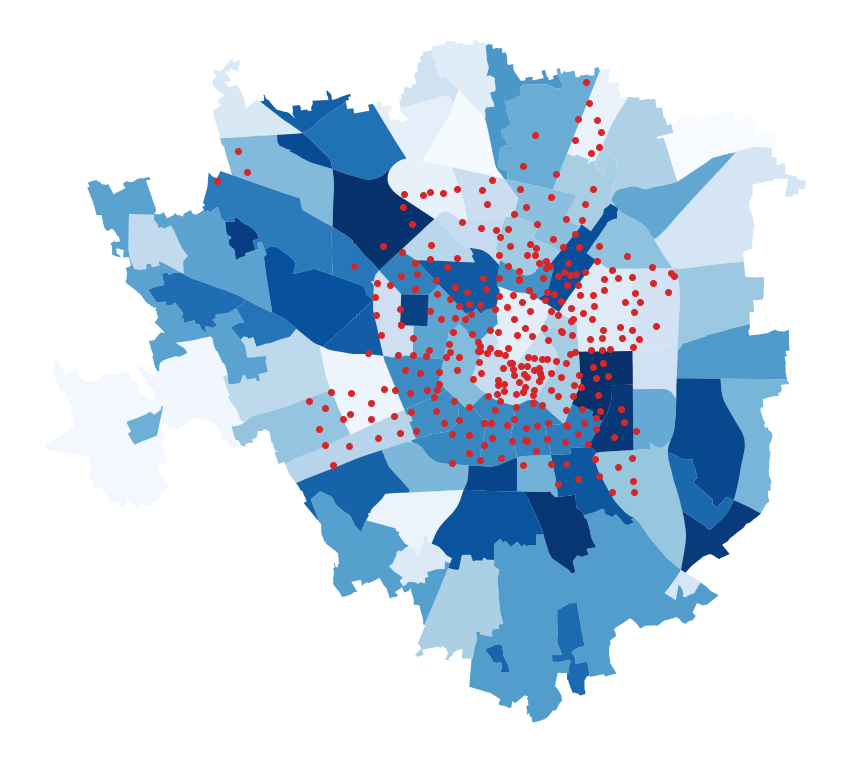

In [6]:
# define ax object and dimensions
fig, ax = plt.subplots(figsize = (15,15))

# plot both objects on the same axes; order matters
nil.plot(ax = ax, cmap = "Blues")
bikemi_stalls.plot(ax = ax, color = "tab:red")

# remove the axis lines
plt.axis("off")

plt.show()

Finally, let's load the time series data:

In [5]:
# load the time series for each station in the long format
station_outflow = pd.read_csv("../data/bikemi_csv/station_daily_outflow.csv", parse_dates=[0], index_col=[0])

station_outflow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104589 entries, 2019-12-31 to 2019-01-01
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   stazione_partenza  104589 non-null  object
 1   count              104589 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


# First Join: Bikemi Stalls and Time Series Data

In [7]:
# join the index of the table specified as the first argument on the column specified by the "on" argument
outflow_geo = geopandas.GeoDataFrame(
    # the data to pass as first argument:
    station_outflow.join(bikemi_stalls, on = "stazione_partenza") \
    .sort_values(["giorno_partenza", "stazione_partenza"], ascending = True),
    # then set the coordinate reference system
    crs = "EPSG:4326"
)

In [9]:
outflow_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 104589 entries, 2019-01-01 to 2019-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   stazione_partenza  104589 non-null  object  
 1   count              104589 non-null  int64   
 2   municipio          91458 non-null   category
 3   geometry           91458 non-null   geometry
dtypes: category(1), geometry(1), int64(1), object(1)
memory usage: 3.3+ MB


Some information is actually lost! There are some observations from the dataset which cannot be matched to the stalls list.

In [81]:
unique_stalls = pd.Series(bikemi_stalls.index.unique())
unique_stations_outflow = pd.Series(station_outflow["stazione_partenza"].sort_values(ascending=True).unique(), name = "stazione_partenza")

print(f"""
Number of stalls in the official data: {unique_stalls.size}.
Number of stalls in our time series: {unique_stations_outflow.size}.
""")


Number of stalls in the official data: 319.
Number of stalls in our time series: 306.



In [61]:
def anti_join(x, y, on):
    """Return rows in x which are not present in y"""

    if type(on) is list:
        ans = pd.merge(left=x, right=y, how='left', indicator=True, left_on=on[0], right_on=on[1])
    elif type(on) is str:
        ans = pd.merge(left=x, right=y, how='left', indicator=True, on=on)
    else:
        raise Exception("Please insert either a list of two elements or a string for the argument `on`")

    ans = ans.loc[ans._merge == 'left_only', :].drop(columns='_merge')
    return ans

In [82]:

mismatched_stations = anti_join(unique_stations_outflow, unique_stalls, on = ["stazione_partenza", "nome"])["stazione_partenza"]

mismatched_stalls = anti_join(unique_stalls, unique_stations_outflow, on = ["nome", "stazione_partenza"])["nome"]

print(f"""
{mismatched_stations.size} are present only in the time series data.
{mismatched_stalls.size} are present only in the stalls data.
""")


40 are present only in the time series data.
53 are present only in the stalls data.



To deal with this, we have to turn to snake_case all station names, then perform the join again. We will have to use regular expressions. As Jamie Zawinski said in 1997:

> Some people, when confronted with a problem, think: "I know, I'll use regular expressions". Now they have two problems.

In [108]:
# thank you stackoverflow

stalls_renamed = bikemi_stalls.reset_index()["nome"].apply(lambda x: re.sub("[^0-9a-zA-Z]+", "_", x).lower())

In [ ]:
stations_renamed = unique_stations_outflow.reset_index()["stazione_partenza"].apply(lambda x: re.sub("[^0-9a-zA-Z]+", "_", x).lower())


In [113]:
stations_renamed.name

'stazione_partenza'

In [114]:
anti_join(stations_renamed, stalls_renamed, on = [stations_renamed.name, stalls_renamed.name])

,stazione_partenza,nome
21,bastioni_di_porta_venezia_chiusa_provv_,NaN
31,bocconi_2_bach,NaN
61,cant_,NaN
63,carlini_dalviano,NaN
101,donizetti_provincia_,NaN
174,montenero_spartaco,NaN
182,naviglio_g_valenza,NaN
196,piazza_nizza,NaN
234,san_gimignano_tuberose,NaN
243,sant_agostino_chiusa_provvisoriamente_,NaN


# Spatial Joins

Let's proceed with a spatial operation, to assign each stall to its NIL, i.e. neighbourhood. The spatial operations can be:

* `intersects`: 
* `contains`
* `within`
* `touches`
* `crosses`
* `overlaps`

In [10]:
outflow_geo_nil = geopandas.sjoin(outflow_geo, nil, how="inner", op = "intersects")

In [14]:
outflow_geo_nil = outflow_geo_nil\
    .sort_values(["giorno_partenza", "stazione_partenza", "index_right"])\
    .rename_geometry("stalls_geometry")\
    .rename(columns={"index_right":"nil_number"})

In [15]:
outflow_geo_nil

,stazione_partenza,count,municipio,stalls_geometry,nil_number,nil
giorno_partenza,,,,,,
2019-01-01,Accursio - Portello,2,8,POINT (9.14589 45.49091),71,Villapizzone - Cagnola - Boldinasco
2019-01-01,Adamello - Lorenzini,1,5,POINT (9.20310 45.44341),36,Scalo Romana
2019-01-01,Alserio - Cola Montano,7,9,POINT (9.18568 45.49104),11,Isola
2019-01-01,Amendola M1,2,8,POINT (9.15171 45.47364),58,De Angeli - Monte Rosa
2019-01-01,Angilberto - Comacchio,2,4,POINT (9.21749 45.43721),35,Lodi - Corvetto
...,...,...,...,...,...,...
2019-12-31,XXII Marzo,5,4,POINT (9.21247 45.46216),26,Xxii Marzo
2019-12-31,XXIV Maggio,11,5,POINT (9.17955 45.45222),6,Porta Ticinese - Conca Del Naviglio
2019-12-31,XXV Aprile,19,1,POINT (9.18667 45.48017),2,Brera
